# Otto商品分类——SVM

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [25]:
train1 = pd.read_csv('Otto_FE_train_org.csv')
train2 = pd.read_csv("Otto_FE_train_tfidf.csv")

train2 = train2.drop(['id', 'target'], axis=1)

train = pd.concat([train1, train2], axis=1)
train.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84_tfidf,feat_85_tfidf,feat_86_tfidf,feat_87_tfidf,feat_88_tfidf,feat_89_tfidf,feat_90_tfidf,feat_91_tfidf,feat_92_tfidf,feat_93_tfidf
0,1,0.016393,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.075886,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.013158,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.013158,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,4,0.016393,0.0,0.0,0.014286,0.315789,0.1,0.131579,0.000000,0.0,...,0.460983,0.000000,0.008244,0.022456,0.0,0.0,0.000000,0.0,0.0,0.0
4,5,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.124622,0.000000,0.000000,0.0,0.0,0.145988,0.0,0.0,0.0


In [26]:
del train1
del train2

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Columns: 188 entries, id to feat_93_tfidf
dtypes: float64(186), int64(1), object(1)
memory usage: 88.8+ MB


In [28]:
# train = train.sample(n=15000, random_state=66, axis=0)  # pandas.DataFrame.sample 随机选取若干行

# y = train['target']
# X = train.drop(['id', 'target'], axis=1)

# feat_names = X.columns

# from scipy.sparse import csr_matrix

# X = csr_matrix(X)

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=5000, random_state=66)
# X_train = pd.DataFrame(data=X_train.toarray(), columns=feat_names)
# X_train

In [29]:
y = train['target']
X = train.drop(['id', 'target'], axis=1)

feat_names = X.columns

from scipy.sparse import csr_matrix

X = csr_matrix(X)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=5000, train_size=5000, random_state=66)

X_train = pd.DataFrame(data=X_train.toarray(), columns=feat_names)
X_train.shape

(5000, 186)

In [31]:
X_val = pd.DataFrame(data=X_val.toarray(), columns=feat_names)
X_val.shape

(5000, 186)

In [32]:
y_train.shape, y_val.shape

((5000,), (5000,))

### 默认参数的 LinearSVC

In [33]:
lsvc1 = LinearSVC()
lsvc1.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [34]:
y_predict = lsvc1.predict(X_val)
y_predict[:5]

array(['Class_2', 'Class_9', 'Class_3', 'Class_5', 'Class_2'],
      dtype=object)

In [35]:
#accuracy_score(y_val, y_predict)
print('准确率为：', lsvc1.score(X_val, y_val), '\n')

print("Classification report for classifier %s:\n%s\n" % (lsvc1, classification_report(y_val, y_predict)))

print("Confusion matrix:\n%s" % confusion_matrix(y_val, y_predict))

准确率为： 0.7528 

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

    Class_1       0.52      0.27      0.35       163
    Class_2       0.66      0.84      0.74      1296
    Class_3       0.49      0.37      0.42       612
    Class_4       0.57      0.11      0.19       230
    Class_5       0.94      0.96      0.95       208
    Class_6       0.92      0.92      0.92      1134
    Class_7       0.66      0.55      0.60       225
    Class_8       0.84      0.92      0.88       710
    Class_9       0.80      0.85      0.83       422

avg / total       0.74      0.75      0.73      5000


Confusion matrix:
[[  44   15    3    1    0   11    3   50   36]
 [   1 1083  157    9    7    7   13    6   13]
 [   2  352  228    4    0    5

In [36]:
cross_val_score(lsvc1, X_train, y_train, cv=3).mean()

0.7513963064861269

### LinearSVC正则参数调优
LinearSVC 需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1）

In [37]:
C_s = np.logspace(-1, 3, 5)
penalty_s = ['l1','l2']
param_grid = dict(penalty = penalty_s, C = C_s)

In [39]:
lsvc2 = LinearSVC(dual=False)
grid = GridSearchCV(lsvc2, param_grid, cv=3, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [40]:
grid.best_estimator_

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [41]:
grid.best_params_

{'C': 1.0, 'penalty': 'l2'}

In [42]:
grid.best_score_

0.7514

In [43]:
grid.cv_results_

{'mean_fit_time': array([0.51704399, 0.2091434 , 4.20856849, 0.42160145, 7.78843403,
        0.70894321, 8.90784558, 1.76354448, 8.22232779, 4.5480206 ]),
 'mean_score_time': array([0.15334646, 0.15424895, 0.08157508, 0.14155189, 0.06118576,
        0.18894243, 0.00749294, 0.06293631, 0.00763051, 0.0082616 ]),
 'mean_test_score': array([0.7282, 0.7406, 0.749 , 0.7514, 0.7428, 0.7458, 0.7302, 0.7392,
        0.7232, 0.7316]),
 'mean_train_score': array([0.73600002, 0.75929993, 0.78779874, 0.79240065, 0.82789866,
        0.81879901, 0.84029967, 0.83099907, 0.84300027, 0.83989867]),
 'param_C': masked_array(data=[0.1, 0.1, 1.0, 1.0, 10.0, 10.0, 100.0, 100.0, 1000.0,
                    1000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1',
                    'l2'],
              mask

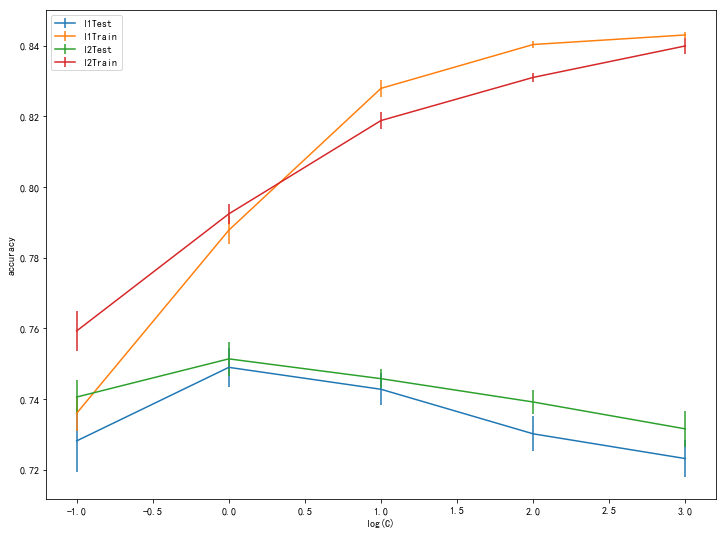

In [44]:
mean_test_score = grid.cv_results_['mean_test_score']
std_test_score = grid.cv_results_['std_test_score']

mean_train_score = grid.cv_results_['mean_train_score']
std_train_score = grid.cv_results_['std_train_score']

n_Cs = len(C_s)
n_penaltys = len(penalty_s)

test_scores = mean_test_score.reshape(n_Cs, n_penaltys)
train_scores = mean_train_score.reshape(n_Cs, n_penaltys)
test_stds = std_test_score.reshape(n_Cs, n_penaltys)
train_stds = std_train_score.reshape(n_Cs, n_penaltys)

plt.figure(figsize=(12, 9))

x_axis = np.log10(C_s)
for i in range(n_penaltys):
    plt.errorbar(x_axis, test_scores[:, i], yerr=test_stds[:, i], label=penalty_s[i] + 'Test')
    plt.errorbar(x_axis, train_scores[:, i], yerr=train_stds[:, i], label=penalty_s[i] + 'Train')
    
plt.legend()
plt.xlabel('log(C)')                                                                                                      
plt.ylabel('accuracy')
plt.axis()
plt.show()

### SVC正则参数调优

In [45]:
param_grid=[
    {'C':[0.1,1,10,100,1000],'kernel':['linear']}, 
    {'C':[0.1,1,10,100,1000],'gamma':[0.1,1,10],'kernel':['rbf']}
]

svc = SVC(cache_size=2000)

grid = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=28000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 1, 10], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [46]:
grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [47]:
grid.best_score_

0.7704

In [48]:
grid.cv_results_

{'mean_fit_time': array([ 3.61599541,  2.35104513,  2.31924764,  3.32764173, 10.87300976,
         7.51762001,  6.30474011, 14.872449  ,  4.0714399 ,  4.50807921,
        14.89587625,  2.93522064,  4.68482931, 15.02736553,  3.08564091,
         4.73327827, 14.24420746,  3.58210055,  4.55658197,  9.4256115 ]),
 'mean_score_time': array([1.83504923, 1.55171378, 1.45076783, 1.4204007 , 1.39262867,
        2.90251104, 2.51593582, 3.40109913, 2.12350996, 2.19303163,
        3.24762567, 1.86185884, 2.28047991, 3.3010931 , 1.86164927,
        2.21824384, 1.91083471, 1.81132285, 1.81951078, 1.42422358]),
 'mean_test_score': array([0.7242, 0.7532, 0.753 , 0.7276, 0.7182, 0.6684, 0.7044, 0.2766,
        0.733 , 0.7606, 0.5176, 0.7588, 0.7704, 0.5334, 0.7644, 0.7608,
        0.5326, 0.7404, 0.7558, 0.5326]),
 'mean_train_score': array([0.73189847, 0.78410014, 0.83919902, 0.88089649, 0.903698  ,
        0.67089863, 0.71589761, 0.28019939, 0.74619942, 0.84399707,
        0.98900009, 0.81939976, 0.9

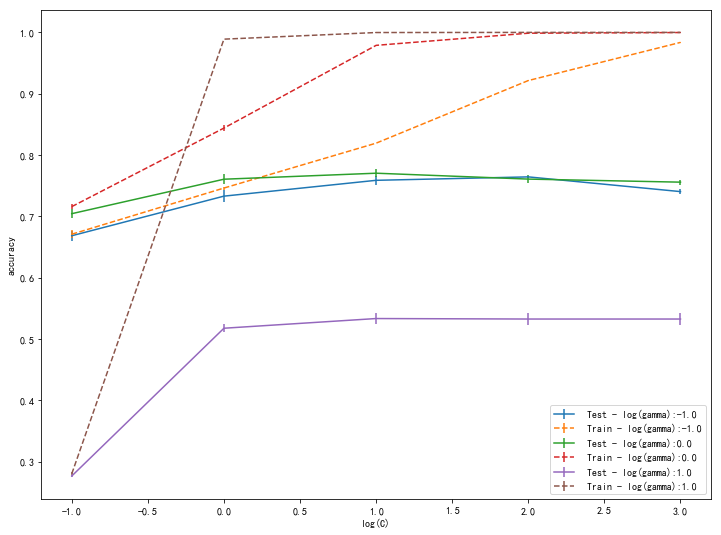

In [49]:
mean_test_score = grid.cv_results_['mean_test_score']
std_test_score = grid.cv_results_['std_test_score']

mean_train_score = grid.cv_results_['mean_train_score']
std_train_score = grid.cv_results_['std_train_score']

n_Cs = len([0.1,1,10,100,1000])
gammas = [0.1,1,10]
n_gammas = len(gammas)

test_scores = mean_test_score[5:].reshape(n_Cs, n_gammas)
train_scores = mean_train_score[5:].reshape(n_Cs, n_gammas)
test_stds = std_test_score[5:].reshape(n_Cs, n_gammas)
train_stds = std_train_score[5:].reshape(n_Cs, n_gammas)

plt.figure(figsize=(12, 9))

x_axis = np.log10([0.1,1,10,100,1000])
for i in range(3):
    plt.errorbar(x_axis, test_scores[:, i], yerr=test_stds[:, i], label=' Test - log(gamma):' + str(np.log10(gammas[i])))  
    plt.errorbar(x_axis, train_scores[:, i], yerr=train_stds[:, i], linestyle='--', label=' Train - log(gamma):' + str(np.log10(gammas[i]))) 
    
plt.legend()
plt.xlabel('log(C)')                                                                                                      
plt.ylabel('accuracy')
plt.axis()
plt.show()